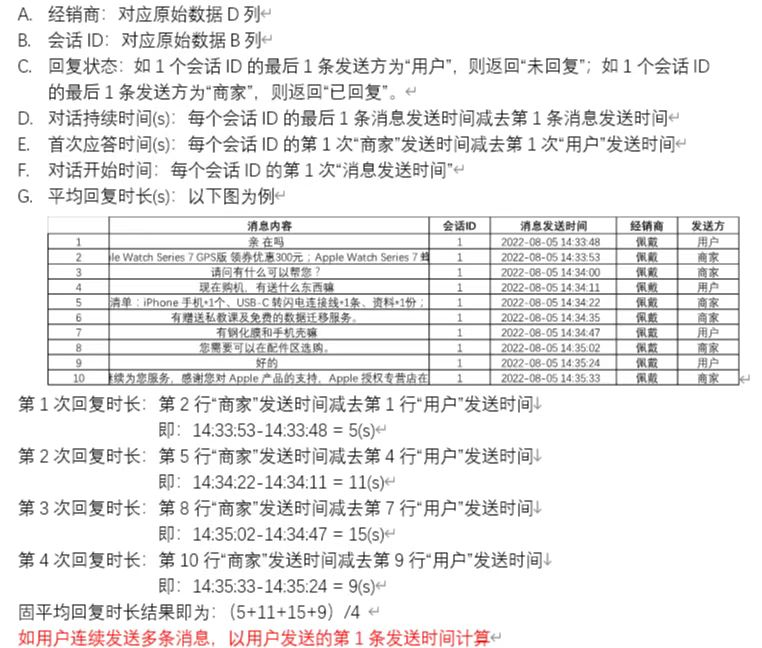

In [1]:
# 插入题目的图片

from IPython.display import Image
Image(filename="./题目.jpg")

### **需求：** 数据结果列为：经销商、会话ID、回复状态、对话持续时间(s)、首次应答时间(s)、对话开始时间、平均回复时长(s)

In [2]:
# 查看数据表

import pandas as pd
import numpy as np
import xlwings as xw
from alive_progress import alive_bar
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('./原始数据.xlsx',sheet_name='Sheet1')
df.head()

,消息内容,会话ID,消息发送时间,经销商,发送方
0,亲 在吗\t\n,1,2022-08-05 14:33:48\t\n,佩戴,用户
1,您好，欢迎光临 Apple 授权专营店，很高兴为您服务！\n\niPhone 13 系列领券...,1,2022-08-05 14:33:53\t\n,佩戴,商家
2,请问有什么可以帮您？\t\n,1,2022-08-05 14:34:00\t\n,佩戴,商家
3,现在购机，有送什么东西嘛\t\n,1,2022-08-05 14:34:11\t\n,佩戴,用户
4,您好，iPhone 官方标配的清单：iPhone 手机*1个、USB-C 转闪电连接线*1条...,1,2022-08-05 14:34:22\t\n,佩戴,商家


In [3]:
# 查看数据列格式

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   消息内容    682 non-null    object
 1   会话ID    682 non-null    int64 
 2   消息发送时间  682 non-null    object
 3   经销商     682 non-null    object
 4   发送方     682 non-null    object
dtypes: int64(1), object(4)
memory usage: 26.8+ KB


In [4]:
# 转换日期时间格式

df['消息发送时间'] = df['消息发送时间'].str.strip()
df['消息发送时间'] = pd.to_datetime(df['消息发送时间'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   消息内容    682 non-null    object        
 1   会话ID    682 non-null    int64         
 2   消息发送时间  682 non-null    datetime64[ns]
 3   经销商     682 non-null    object        
 4   发送方     682 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 26.8+ KB


In [5]:
# 对话开始时间

first_time_tb = df.groupby(['经销商','会话ID'])['消息发送时间'].min().reset_index()
first_time_tb = first_time_tb.sort_values(by='会话ID')
first_time_tb

,经销商,会话ID,消息发送时间
6,佩戴,1,2022-08-05 14:33:48
7,佩戴,2,2022-08-04 10:42:36
8,佩戴,3,2022-08-01 10:16:38
9,佩戴,4,2022-08-01 10:04:48
10,佩戴,5,2022-07-31 22:29:27
...,...,...,...
71,酷动,14903,2022-07-31 21:19:57
72,酷动,14904,2022-07-31 18:22:59
73,酷动,14905,2022-07-31 17:49:33
74,酷动,14906,2022-07-31 15:44:26


In [6]:
# 对话结束时间

last_time_tb = df.groupby(['经销商','会话ID'])['消息发送时间'].max().reset_index()
last_time_tb = last_time_tb.sort_values(by='会话ID')
last_time_tb

,经销商,会话ID,消息发送时间
6,佩戴,1,2022-08-05 14:35:33
7,佩戴,2,2022-08-04 10:43:19
8,佩戴,3,2022-08-01 10:19:02
9,佩戴,4,2022-08-01 10:06:52
10,佩戴,5,2022-07-31 22:29:59
...,...,...,...
71,酷动,14903,2022-07-31 21:22:07
72,酷动,14904,2022-07-31 18:26:03
73,酷动,14905,2022-07-31 17:52:56
74,酷动,14906,2022-07-31 15:49:36


In [7]:
# 对话持续时长

df_duration =  df.groupby(['经销商','会话ID'])['消息发送时间'].max() - df.groupby(['经销商','会话ID'])['消息发送时间'].min()
df_duration = df_duration.reset_index().sort_values(by='会话ID')
df_duration['对话持续时长(s)'] = df_duration['消息发送时间'].apply(lambda x : x.seconds)
df_duration = df_duration[['经销商','会话ID','对话持续时长(s)']]
df_duration

,经销商,会话ID,对话持续时长(s)
6,佩戴,1,105
7,佩戴,2,43
8,佩戴,3,144
9,佩戴,4,124
10,佩戴,5,32
...,...,...,...
71,酷动,14903,130
72,酷动,14904,184
73,酷动,14905,203
74,酷动,14906,310


In [8]:
# 对话首次应答时间

df_shop = df[df['发送方']=='商家']
first_answer_tb = df_shop.groupby(['经销商','会话ID'])['消息发送时间'].min() - df.groupby(['经销商','会话ID'])['消息发送时间'].min()
first_answer_tb = first_answer_tb.reset_index().sort_values(by='会话ID')
first_answer_tb['首次应答时长(s)'] = first_answer_tb['消息发送时间'].apply(lambda x : x.seconds)
first_answer_tb = first_answer_tb[['经销商','会话ID','首次应答时长(s)']]
first_answer_tb

,经销商,会话ID,首次应答时长(s)
6,佩戴,1,5.0
7,佩戴,2,6.0
8,佩戴,3,63.0
9,佩戴,4,8.0
10,佩戴,5,26.0
...,...,...,...
71,酷动,14903,7.0
72,酷动,14904,4.0
73,酷动,14905,5.0
74,酷动,14906,99.0


In [9]:
# 定义回复状态函数

def session_state(x):
    if x=='商家':
        return '已回复'
    elif x=='用户':
        return '未回复'
    else:
        return ''

In [10]:
# 确定回复状态

df_state = pd.merge(last_time_tb,df,on=['经销商','会话ID','消息发送时间'],how='inner')
df_state = df_state[['经销商','会话ID','发送方']]
df_state = df_state.sort_values(by='会话ID')
df_state['状态'] = df_state['发送方'].apply(session_state)
df_state = df_state[['经销商','会话ID','状态']]
df_state

,经销商,会话ID,状态
0,佩戴,1,已回复
1,佩戴,2,已回复
2,佩戴,3,已回复
3,佩戴,4,已回复
4,佩戴,5,已回复
...,...,...,...
71,酷动,14903,已回复
72,酷动,14904,已回复
73,酷动,14905,已回复
74,酷动,14906,已回复


In [11]:
# 计算平均回复时长

df_temp = df[['会话ID','消息发送时间','经销商','发送方']]
df_temp['辅助列1'] = df_temp['发送方'].shift(1)
df_diff = df_temp[df_temp['辅助列1']!=df_temp['发送方']]
df_diff['辅助列2'] = df_diff['消息发送时间'].shift(1)
df_diff['回复时长'] = (df_diff['消息发送时间'] - df_diff['辅助列2']).apply(lambda x : x.seconds)
df_diff = df_diff.dropna()
df_diff = df_diff[df_diff['发送方']=='商家']
df_avg_time = df_diff.groupby(['会话ID','经销商']).agg({'回复时长':'sum','发送方':'count'}).reset_index()
df_avg_time['平均回复时长(s)'] = df_avg_time['回复时长'] / df_avg_time['发送方']  
df_avg_time = df_avg_time[['会话ID','经销商','平均回复时长(s)']]
df_avg_time

,会话ID,经销商,平均回复时长(s)
0,1,佩戴,10.0
1,2,佩戴,13.5
2,3,佩戴,63.0
3,4,佩戴,37.5
4,5,佩戴,26.0
...,...,...,...
68,14903,酷动,24.0
69,14904,酷动,17.0
70,14905,酷动,20.0
71,14906,酷动,54.5


In [12]:
# 最终结果拼接

df_result = pd.merge(df_state,df_duration,on=['经销商','会话ID'],how='left')
df_result = pd.merge(df_result,first_answer_tb,on=['经销商','会话ID'],how='left')
df_result = pd.merge(df_result,first_time_tb,on=['经销商','会话ID'],how='left')
df_result = pd.merge(df_result,df_avg_time,on=['经销商','会话ID'],how='left')
df_result.rename(columns={'消息发送时间':'对话开始时间'},inplace=True)
df_result['平均回复时长(s)'] = df_result['平均回复时长(s)'].fillna(0)
df_result['平均回复时长(s)'] = df_result['平均回复时长(s)'].astype('int')
df_result

,经销商,会话ID,状态,对话持续时长(s),首次应答时长(s),对话开始时间,平均回复时长(s)
0,佩戴,1,已回复,105,5.0,2022-08-05 14:33:48,10
1,佩戴,2,已回复,43,6.0,2022-08-04 10:42:36,13
2,佩戴,3,已回复,144,63.0,2022-08-01 10:16:38,63
3,佩戴,4,已回复,124,8.0,2022-08-01 10:04:48,37
4,佩戴,5,已回复,32,26.0,2022-07-31 22:29:27,26
...,...,...,...,...,...,...,...
71,酷动,14903,已回复,130,7.0,2022-07-31 21:19:57,24
72,酷动,14904,已回复,184,4.0,2022-07-31 18:22:59,17
73,酷动,14905,已回复,203,5.0,2022-07-31 17:49:33,20
74,酷动,14906,已回复,310,99.0,2022-07-31 15:44:26,54


In [13]:
# 输出结果表

df_result.to_excel('./reslut.xlsx',index=False)

app = xw.App(visible=False,add_book=False)
workbook = app.books.open('./reslut.xlsx')

with alive_bar(len(workbook.sheets)) as bar:    
    for i in workbook.sheets:
        bar()
        # pbar.set_description(f'Processing {i}')
    # 批量设置格式（行高、列宽、字体、大小、线框）
        value = i.range('A1').expand() # 选择要调整的区域
        value.rows.autofit() # 调整列宽字符宽度
        value.columns.autofit()  # 调整行高字符宽度
        value.api.Font.Name = '微软雅黑' # 设置字体
        value.api.Font.Size = 9 # 设置字号大小（磅数）
        value.api.VerticalAlignment = xw.constants.VAlign.xlVAlignCenter # 设置垂直居中
        value.api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter # 设置水平居中
        for cell in value:
            for b in range(7,12):
                cell.api.Borders(b).LineStyle = 1 # 设置单元格边框线型
                cell.api.Borders(b).Weight = 2 # 设置单元格边框粗细
        value = i.range('A1:M1')  # 选择要调整的区域
        value.api.Font.Size = 10
        value.api.Font.Bold = True  # 设置为粗体
        # print(f'《{i.name}》 页面处理完成……')
workbook.save()
workbook.close()
app.quit()

print(f'\n表格输出完成！！')

|████████████████████████████████████████| 1/1 [100%] in 11.2s (0.09/s) 

表格输出完成！！


### 其他大佬实现的代码，参考学习

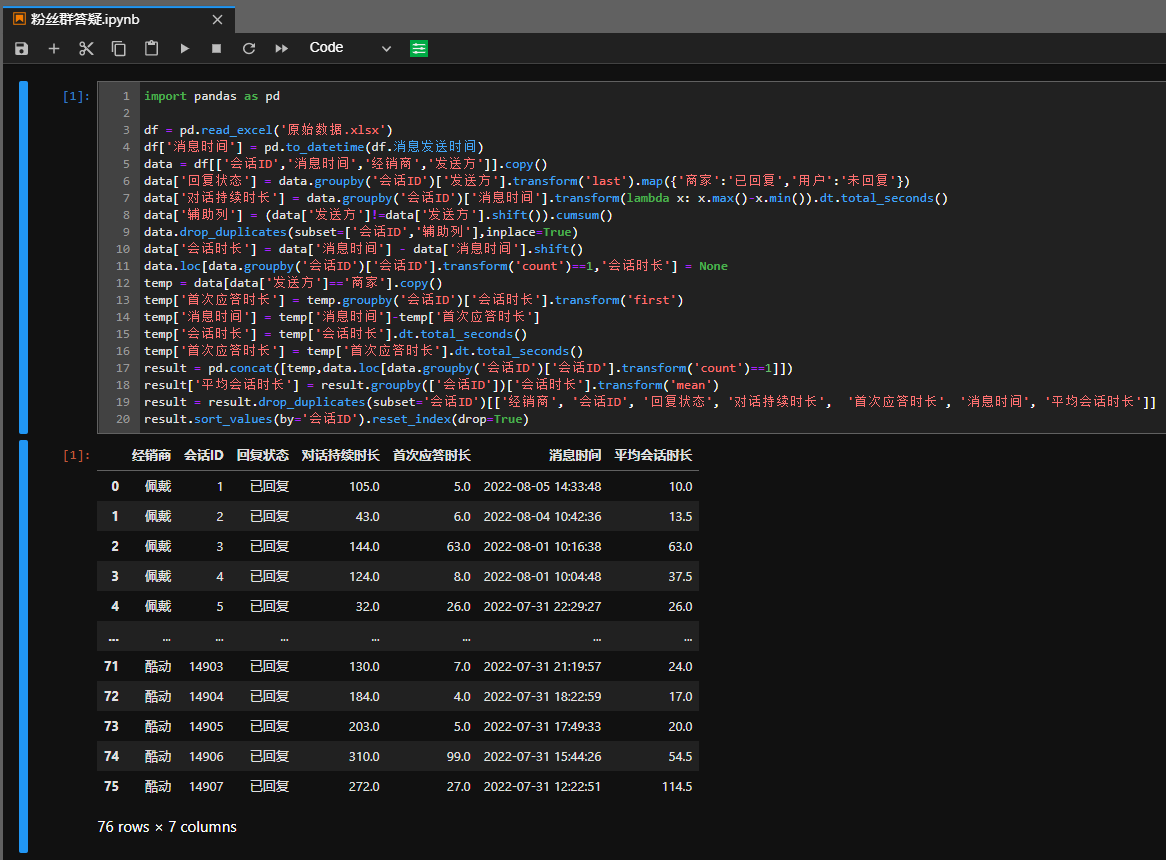

In [14]:
Image(filename="./大佬代码1.png")

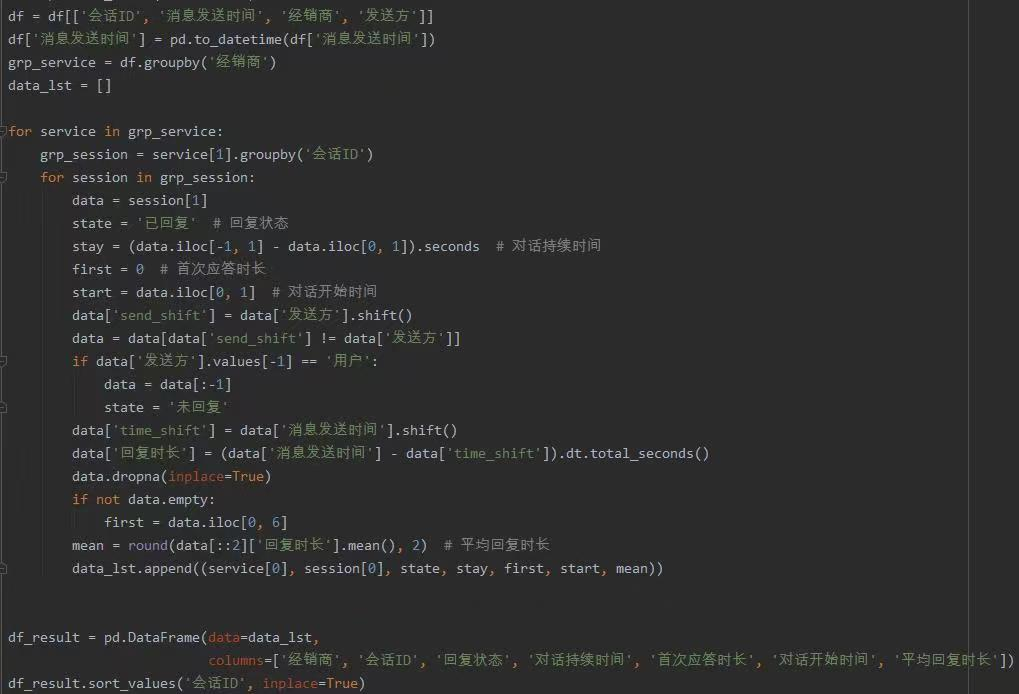

In [15]:
Image(filename="./大佬代码2.jpg")

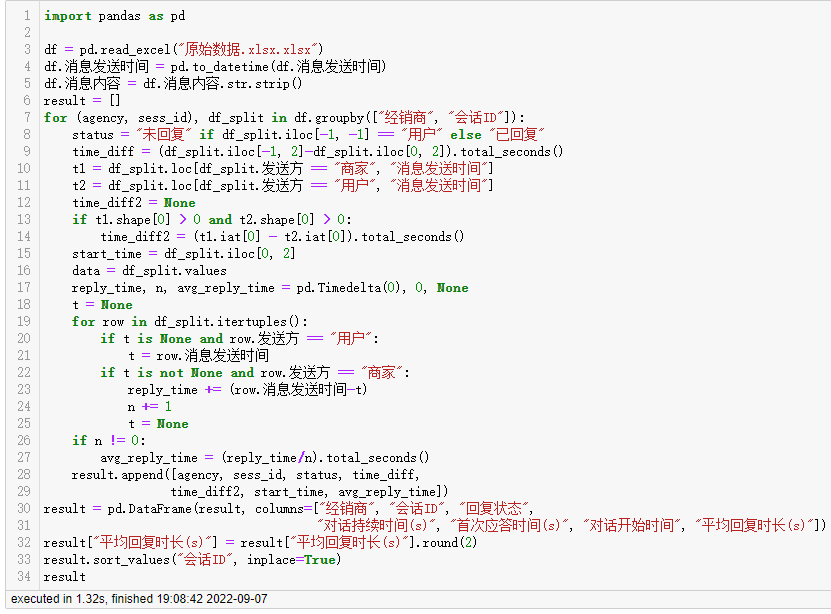

In [16]:
Image(filename="./大佬代码3-1.png")

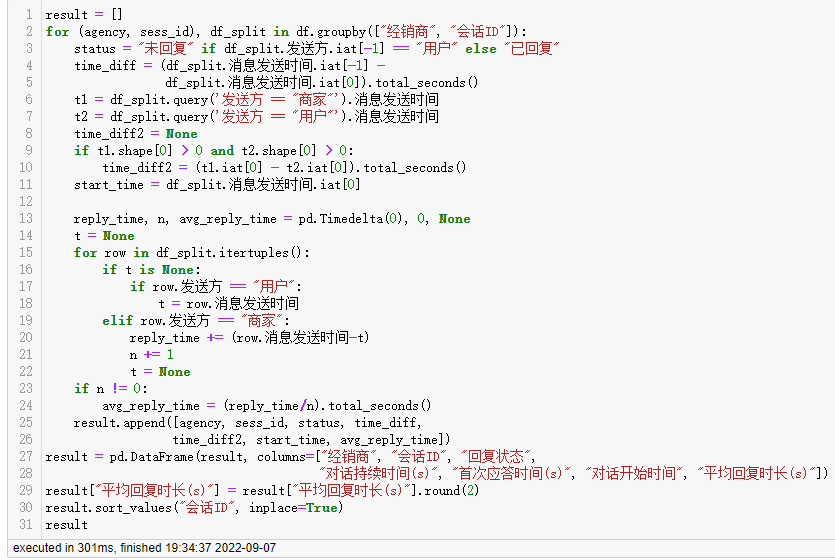

In [17]:
Image(filename="./大佬代码3-2.png")

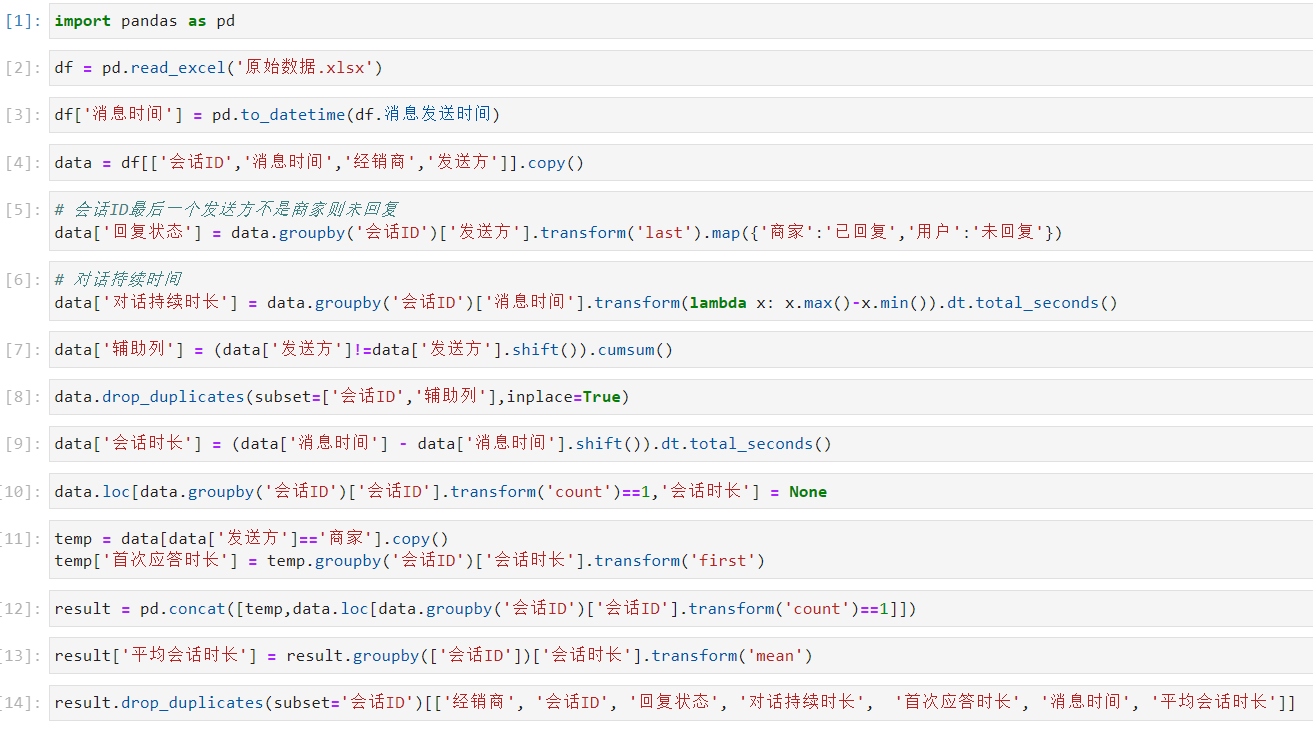

In [18]:
Image(filename="./大佬代码4.png")

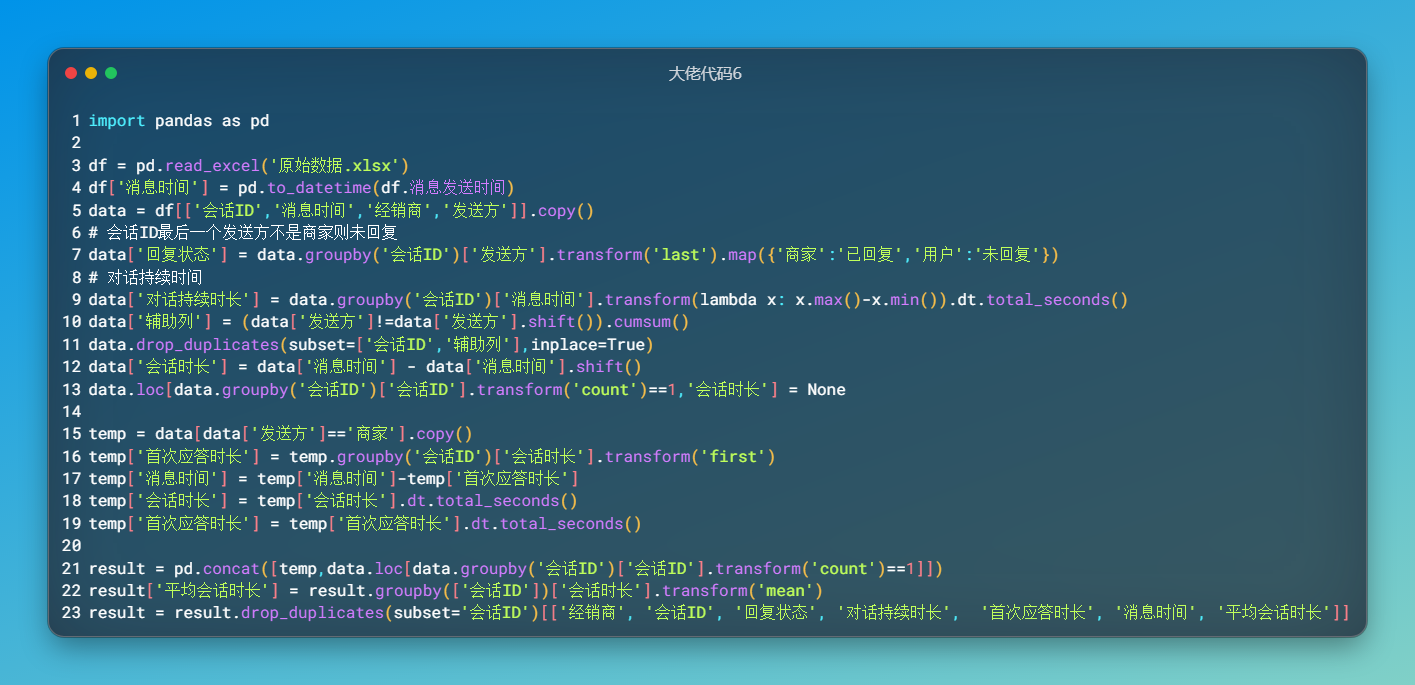

In [19]:
Image(filename="./大佬代码5.png")